## 3D-trajectory introduction

This is jupyter notebook for a gentle introducion to the properties of 3D trajectories.

In [1]:
import partitura
import numpy as np
import itertools
import sys, os
import networkx as nx
from scipy.sparse import csr_matrix 
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.dirname(os.getcwd())+ '\\source')

from trajectory import buildTrajectory
from  trajectory import weightsOfTrajPoints_Normalized
from trajectory import SetOfPoints

In [2]:
XLM_DIR = os.path.dirname(os.getcwd()) + "\\samples\\data\\xml\\"


def note_array2chords(note_array):
    '''Group note_array list by time, effectively to chords.
    
    Parameters
    ----------
    note_array : array(N, 5)
        The partitura note_array object. Every entry has 5 attributes, i.e. onset_time, note duration, note velocity, voice, id.
        
    Returns
    -------
    chords : list(list(tuples))
    '''
    note_array = [(n[0], n[1], n[2]) for n in note_array]
    chords = [list(item[1]) for item in itertools.groupby(sorted(note_array), key=lambda x: x[0])]
    for i in range(1, len(chords)):
        temp = []
        # 
        for chordTriplePrev in chords[i-1]:
            for chordTripleNext in chords[i]:
                if chordTripleNext[0] < chordTriplePrev[1]+chordTriplePrev[0] and (chordTripleNext[0], chordTriplePrev[1], chordTriplePrev[2]) not in temp:
                    temp.append((chordTripleNext[0], chordTriplePrev[1], chordTriplePrev[2]))
        chords[i] = chords[i] + temp
    return chords


def trajectory_edges(trajectory):
    TotalEdges = []
    dist = [-1, 0, 1]
    for dicts in trajectory.chordPositions :
        couples = list(itertools.combinations(dicts.values(), 2))
        for couple in couples:
            (x1, y1, z1), (x2, y2, z2) = couple
            if (x1 - x2) in dist and (y1 - y2) in dist:
                    if not (((x1 - x2) == 1 and (y1 - y2) == -1) or
                            ((x1 - x2) == -1 and (y1 - y2) == 1)):
                        TotalEdges.append(couple)
                        # also the copy for an undirected graph
                        # in the level of the chords but not on the level of transitions
                        TotalEdges.append((couple[1], couple[0]))
    return TotalEdges


def trajectory_to_adjacency(trajectory):
    '''Compute the adjacency matrix of the trajectory graph.
    
    Parameters:
    -----------
    trajectory : object
        The harmonic trajectory in 3D of some piece or segment.
    
    Returns:
    --------
    adjacency : array(float)
        The adjacency matrix of the weighted trajectory graph as a normalized array of floats.
    '''
    ps, pms = SetOfPoints(trajectory)
    edges = trajectory_edges(trajectory)
    edges += trajectory.connectingEdges
    weights = weightsOfTrajPoints_Normalized(ps, pms)
    dim = len(ps)
    adjacency = np.zeros((dim, dim))
    for i in range(dim):  
        for j in range(dim):
            if (ps[i], ps[j]) in edges:
                adjacency[i][j] += (weights[ps[i]] + weights[ps[j]])/2
    return adjacency
    

def node_weights(trajectory, durations):
    '''
    Calculate the node weights based on the duration of the notes.
    
    Parameters
    ----------
    trajectory : object
        We just use the trajectory.chordPositions
    
    durations : list(dict(pitch : duration))
        A list of dictionaries with keys the n-th chord's note pitch and value its duration.
    
    
    Returns : node_weight_dict
        A dictionary with keys the trajectory positions and value their summed duration. 
    '''
    positions_weights = [dict(zip(pos_dict.values(), dur_dict.values())) 
                     for pos_dict, dur_dict in zip(trajectory.chordPositions, durations)
                    ]
    node_weight_dict = dict()
    set_of_points, _ = SetOfPoints(trajectory)
    for point in set_of_points :
        for pos_weight in positions_weights:
            if point in pos_weight.keys():
                if point in node_weight_dict.keys():
                    node_weight_dict[point] += pos_weight[point] 
                else :
                    node_weight_dict[point] = pos_weight[point] 
    return(node_weight_dict)


def adjacency_to_sparse(adjacency):
    sparsity = 1.0 - np.count_nonzero(adjacency) / adjacency.size
    print(sparsity)
    if sparsity > 0.7 :
        return csr_matrix(adjacency)
    else :
        print("Adjacency matrix is not sparce enought to compute sparce matrix")

In [9]:
part = partitura.load_musicxml(XLM_DIR + "simple_test.musicxml")

note_array = part.note_array
print(note_array.dtype)
chords = note_array2chords(note_array)
durations = [dict(zip(list(zip(*c))[2], list(zip(*c))[1]))  for c in chords]
chords = [list(zip(*c))[2] for c in chords]
# print(chords)

[('onset', '<f4'), ('duration', '<f4'), ('pitch', '<i4'), ('voice', '<i4'), ('id', '<U256')]


In [10]:
Tonnetz = [3, 4, 5]
trajectory = buildTrajectory(chords, Tonnetz)


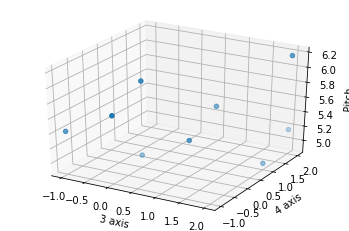

In [11]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from  trajectory import SetOfPoints

ps, pms = SetOfPoints(trajectory)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = zip(*ps)

ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel('3 axis')
ax.set_ylabel('4 axis')
ax.set_zlabel('Pitch')

plt.show()

### Graph from Adjacency Matrix


With node attributes the notes' durations!

81


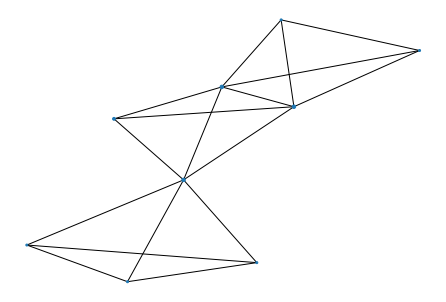

In [12]:
adjacency = trajectory_to_adjacency(trajectory)
G = nx.from_numpy_array(adjacency, parallel_edges=False, create_using=None)

weights = [node_weights(trajectory, durations)[p] for p in SetOfPoints(trajectory)[0]]
norm_weights = list(map(lambda w : float(w) / max(weights), weights))
bb = dict(zip(G.nodes, norm_weights))
nx.set_node_attributes(G, bb, "size")
print(adjacency.size)
nx.draw(G, node_size=weights)

Let $A$ be a discrete set of values for the node attribute node_attr. Then the elements of $A$ represent the rows and columns of the constructed matrix. Now, iterate through every edge $e=(u,v)$ in $G$ and consider the value of the edge attribute edge_attr. If $u_a$ and $v_a$ are the values of the node attribute node_attr for $u$ and $v$, respectively, then the value of the edge attribute is added to the matrix element at $(u_a, v_a)$.

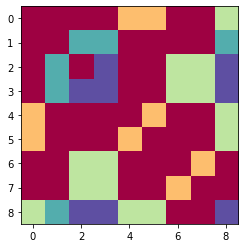

In [13]:
attr_matrix = nx.attr_matrix(G, edge_attr="weight", node_attr="size", normalized=True)

# print(attr_matrix[0].shape)
# print(len(attr_matrix[1]))
# plt.imshow(attr_matrix[0])
plt.imshow(adjacency, cmap='Spectral')



### Making the Trajectory Adjacency matrix a Sparce matrix

First calculate the sparsity of the Trajectory Matrix and if it passes a certain threshold yield a sparce matrix.

0.5555555555555556
Adjacency matrix is not sparce enought to compute sparce matrix


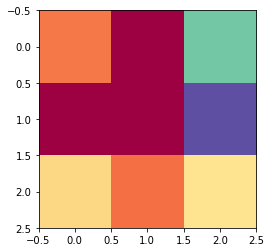

In [14]:
if not isinstance(adjacency_to_sparse(adjacency), str):
    M = nx.attr_sparse_matrix(G, edge_attr="weight", node_attr="size", normalized=True)
    plt.imshow(M[0].todense(), cmap='Spectral')

### Another representation for a graph (attributed uncertain graph)

An attributed uncertain graph is represented as $G = (V, E, F, P)$, where :
- $V$ corresponds to the set of n nodes in $G$; 
- $E \in V \times V$ denotes the undirected edges between nodes; 
- $F$ is a set of $n$ attribute vectors, which indicate the $d$ attributes associated with each node; 
- $P$ maps every pair of nodes to a real number in the interval $[0, 1]$; 
- $p_{uv}$ represent the probability that the edge $(u, v) \in E$ exists.